In [115]:
import Traitement_de_texte as tt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from Traitement_de_texte import preprocess_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, classification_report, f1_score, accuracy_score ,roc_curve
import dill
import logging
from yellowbrick.classifier import DiscriminationThreshold

from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )


### Train/Test split

#### Recharger le train / test split 

In [6]:
chemin = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\train_test_split.dill'
with open(chemin, 'rb') as f:
    x_train, x_test, y_train, y_test = dill.load(f)

In [94]:
# Configurer le logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [7]:
# from Traitement_de_texte2 import preprocess_text

In [8]:
x_train.head()

,keyword,text,has_geo
10497,traumatised,Had a dream (nightmare ) last night that I wor...,1
1462,body%20bags,"There it is, on cue! Body Bags Burrow with the...",0
997,bleeding,it's weird how ppl w vaginas literally spent d...,1
6550,hijacking,17 This short urgent thread bcoz ALTIF BUKHARI...,1
11165,wounded,3. Tens of thousands of American soldiers died...,1


In [9]:
y_train.value_counts(normalize=True).mul(100).round(2)

target
0    81.41
1    18.59
Name: proportion, dtype: float64

### Feature engineering

In [11]:
# Pipeline 
text_preprocessor = Pipeline(steps=[
    ('lemmatizer', FunctionTransformer(preprocess_text)),  # Fonction personnalisée
    ('tfidf', TfidfVectorizer(max_features=6000))
])

# Pipeline pour has_geo (pas de transformation ici, juste un passage direct)
geo_preprocessor = 'passthrough'  

# ColumnTransformer global
preprocessor = ColumnTransformer(transformers=[
    ('text', text_preprocessor, 'text'),        # Pipeline texte principal
    ('keyword', text_preprocessor, 'keyword'),  # Applique le même traitement que pour 'text'
    ('has_geo', geo_preprocessor, ['has_geo'])  # Variable binaire géographique
])

preprocessor


ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('lemmatizer',
                                                  FunctionTransformer(func=<function preprocess_text at 0x000001D8BEB854E0>)),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=6000))]),
                                 'text'),
                                ('keyword',
                                 Pipeline(steps=[('lemmatizer',
                                                  FunctionTransformer(func=<function preprocess_text at 0x000001D8BEB854E0>)),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=6000))]),
                                 'keyword'),
                                ('has_geo', 'passthrough', ['has_geo'])])

In [163]:
from pathlib import Path
import dill

preprocessor.fit(x_train)  

# Définir le chemin pour sauvegarder le preprocessor
MODEL_DIR = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models'
preprocessor_path = Path(MODEL_DIR, "preprocessor.dill")

# 🔄 Sauvegarde du préprocesseur
with open(preprocessor_path, "wb") as f:
    dill.dump(preprocessor, f)

print("✅ Preprocessor sauvegardé avec succès.")


✅ Preprocessor sauvegardé avec succès.


### Dummy Classifier

In [18]:
# Pipeline 
dc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier())  
])

dc_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x000001D8BEB854E0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=6000))]),
                                                  'text'),
                                                 ('keyword',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x000001D8BEB854E0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=6000))]),
                                                  'keyword'),
                                                 ('has_geo', 'passthrough',
                                                  ['has_geo'])])),
                ('clf', DummyClassifier())])

In [22]:
# Training
dc_pipeline.fit(x_train, y_train)

# Predictions & evaluation
dc_y_pred_test = dc_pipeline.predict(x_test)
dc_y_proba_test = dc_pipeline.predict_proba(x_test)[:, 1]

logger.info(f"AUC: {roc_auc_score(y_test, dc_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, dc_y_pred_test)}")

INFO:__main__:AUC: 0.50
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO:__main__:Classificat

### Naive Bayes

In [102]:
# Pipeline
nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', MultinomialNB())
])

nb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x000001D8BEB854E0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=6000))]),
                                                  'text'),
                                                 ('keyword',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x000001D8BEB854E0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=6000))]),
                                                  'keyword'),
                                                 ('has_geo', 'passthrough',
                                                  ['has_geo'])])),
                ('clf', MultinomialNB())])

#### Baseline

In [120]:
# Training

nb_pipeline.fit(x_train, y_train)

# Predictions & evaluation
nb_y_pred_test = nb_pipeline.predict(x_test)
nb_y_proba_test = nb_pipeline.predict_proba(x_test)[:, 1]

logger.info(f"AUC: {roc_auc_score(y_test, nb_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, nb_y_pred_test)}")

INFO:__main__:AUC: 0.85
INFO:__main__:Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1851
           1       0.72      0.38      0.50       423

    accuracy                           0.86      2274
   macro avg       0.80      0.67      0.71      2274
weighted avg       0.84      0.86      0.84      2274



##### Tuning hyperparameters

In [121]:
nb_param_grid = {
    'clf__alpha': [0.01, 0.1, 0.5, 1, 2]  # ici `1` est la valeur par défaut
}

In [122]:
# Cross-validation
cv = StratifiedKFold(n_splits=5) 

# GridSearchCV
nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Training
nb_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : {nb_grid_search.best_params_}")

# Evaluation
nb_y_pred_test_opt = nb_grid_search.predict(x_test)
nb_y_proba_test_opt  = nb_grid_search.predict_proba(x_test)[:, 1]

logger.info(f"AUC : {roc_auc_score(y_test, nb_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, nb_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, nb_y_pred_test_opt):.2f}")


INFO:__main__:Best params : {'clf__alpha': 0.1}
INFO:__main__:AUC : 0.88
INFO:__main__:F1-score : 0.61
INFO:__main__:Accuracy : 0.87


###### on sauvegarde les memes folds pour les autre modéles

In [31]:
import dill
import os

# Créer un répertoire si nécessaire
cv_path = r"C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\cv_stratified_kfold.dill"

with open(cv_path, 'wb') as f:
    dill.dump(cv, f)


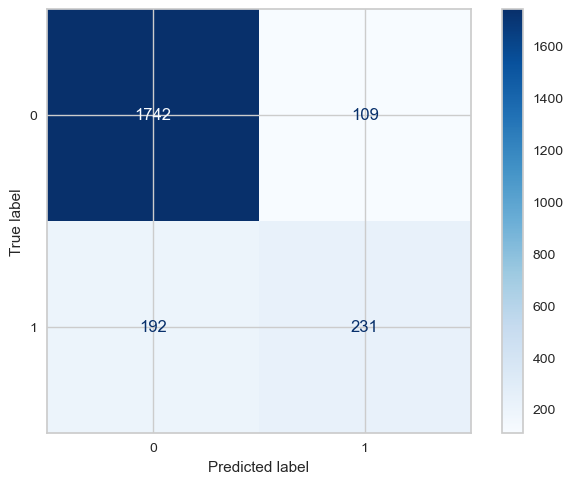

In [144]:
class_names = nb_pipeline.classes_
ConfusionMatrixDisplay.from_estimator(nb_grid_search.best_estimator_, x_test, y_test,
                                      display_labels=class_names,
                                      normalize=None, cmap=plt.cm.Blues);

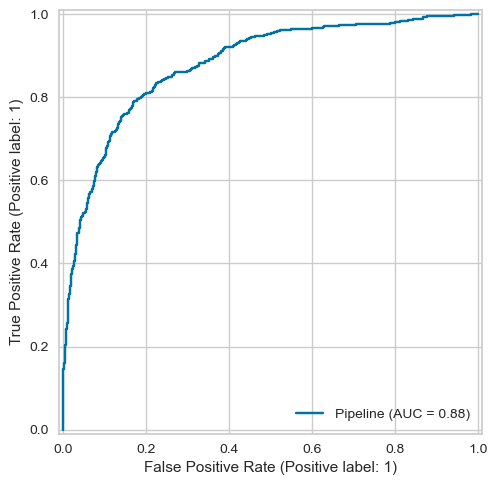

In [145]:
RocCurveDisplay.from_estimator(nb_grid_search.best_estimator_, x_test, y_test)

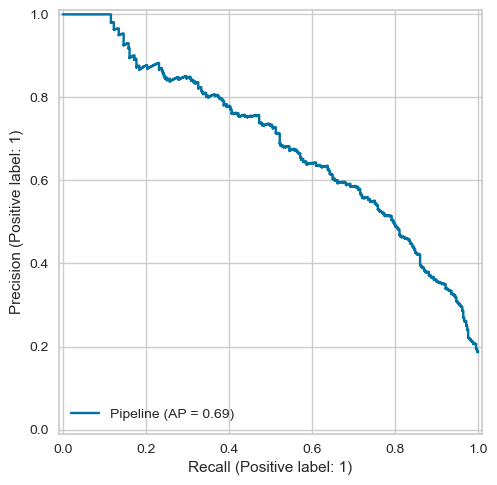

In [146]:
PrecisionRecallDisplay.from_estimator(nb_grid_search.best_estimator_, x_test, y_test);

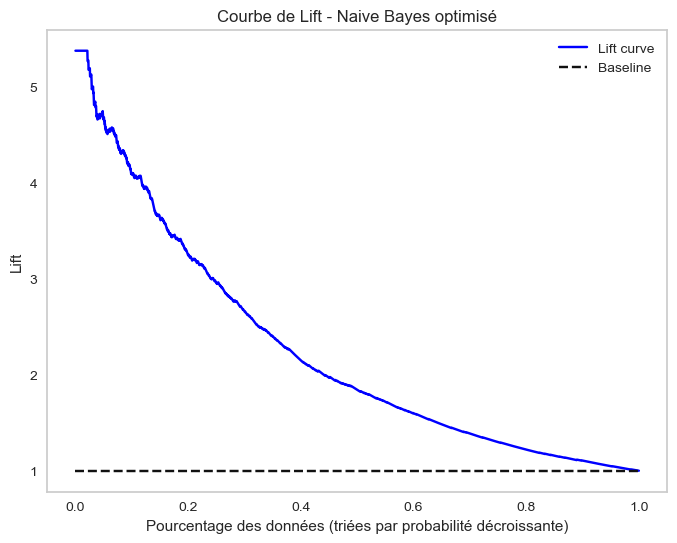

In [147]:
# 1. Prédire les probabilités avec le meilleur modèle
y_pred_proba = nb_grid_search.best_estimator_.predict_proba(x_test)[:, 1]

# 2. Trier les résultats par score décroissant
sorted_indices = np.argsort(y_pred_proba)[::-1]
y_test_sorted = y_test.values[sorted_indices]
y_pred_sorted = y_pred_proba[sorted_indices]

# 3. Calculer le lift
n_samples = len(y_test)
cumulative_y_true = np.cumsum(y_test_sorted)
perc_samples = np.arange(1, n_samples + 1) / n_samples
lift = cumulative_y_true / (perc_samples * cumulative_y_true[-1])

# 4. Tracer la courbe de lift
plt.figure(figsize=(8, 6))
plt.plot(perc_samples, lift, label='Lift curve', color='blue')
plt.plot([0, 1], [1, 1], 'k--', label='Baseline')
plt.xlabel('Pourcentage des données (triées par probabilité décroissante)')
plt.ylabel('Lift')
plt.title('Courbe de Lift - Naive Bayes optimisé')
plt.legend()
plt.grid()
plt.show()



#### Ajustement du seuil

In [124]:

# Séparation en train / validation
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

nb_best_model = nb_grid_search.best_estimator_
# 1. Prédictions sur le jeu de validation
val_proba = nb_best_model.predict_proba(x_val)[:, 1]

# 2. Liste pour stocker les F1-scores pour différents seuils
f1_scores = []

# 3. Varier le seuil de 0 à 1
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    # 4. Générer les prédictions binaires
    y_pred = (val_proba >= threshold).astype(int)
    
    # 5. Calculer le F1-score pour ce seuil
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

# 6. Trouver le seuil qui maximise le F1-score
optimal_f1_threshold = thresholds[np.argmax(f1_scores)]
logger.info(f"Seuil optimal (F1-score, valid set) : {optimal_f1_threshold:.4f}")

# 7. Évaluation finale sur le jeu de test avec ce seuil
test_proba = nb_best_model.predict_proba(x_test)[:, 1]
test_pred_opt_f1 = (test_proba >= optimal_f1_threshold).astype(int)

# 8. Affichage des résultats
logger.info(f"AUC test : {roc_auc_score(y_test, test_proba):.2f}")
logger.info(f"Classification report (seuil optimal sur test) :\n{classification_report(y_test, test_pred_opt_f1)}")


INFO:__main__:Seuil optimal (F1-score, valid set) : 0.3400
INFO:__main__:AUC test : 0.88
INFO:__main__:Classification report (seuil optimal sur test) :
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1851
           1       0.62      0.65      0.63       423

    accuracy                           0.86      2274
   macro avg       0.77      0.78      0.77      2274
weighted avg       0.86      0.86      0.86      2274



In [ ]:
# seuil optimal = 0.3400

### Sauvegarde du model

In [133]:
class NbBestModelOptimized:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict(self, X):
        proba = self.model.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


In [135]:
from pathlib import Path
import dill

# Définir le répertoire et le nom du fichier
MODEL_DIR = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models'
model_path_name = Path(MODEL_DIR, "nb_best_model_optimized.dill")

# Créer l'objet avec le modèle et son seuil
nb_best_model_optimized = NbBestModelOptimized(model=nb_best_model, threshold=optimal_f1_threshold)

# Sauvegarder le modèle et le seuil
logger.info(f"Model path name: {model_path_name}")
with open(model_path_name, "wb") as fp:
    dill.dump(nb_best_model_optimized, fp)

logger.info(f"Model with optimal threshold saved at: {model_path_name}")


INFO:__main__:Model path name: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\nb_best_model_optimized.dill
INFO:__main__:Model with optimal threshold saved at: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\nb_best_model_optimized.dill


### Regression Logistique

In [137]:
# Pipeline
rl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42)) 
])

rl_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x000001D8BEB854E0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=6000))]),
                                                  'text'),
                                                 ('keyword',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   FunctionTransformer(func=<function preprocess_text at 0x000001D8BEB854E0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=6000))]),
                                                  'keyword'),
                                                 ('has_geo', 'passthrough',
                                                  ['has_geo'])])),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

#### Baseline

In [155]:
# Training
rl_pipeline.fit(x_train, y_train)

# Predictions & evaluation
rl_y_pred_test = rl_pipeline.predict(x_test)
rl_y_proba_test = rl_pipeline.predict_proba(x_test)[:, 1]

logger.info(f"AUC: {roc_auc_score(y_test, rl_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, rl_y_pred_test)}")

INFO:__main__:AUC: 0.88
INFO:__main__:Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1851
           1       0.78      0.41      0.54       423

    accuracy                           0.87      2274
   macro avg       0.83      0.69      0.73      2274
weighted avg       0.86      0.87      0.85      2274



##### Tuning hyperparameters

In [65]:
rl_param_grid = {
    'clf__C': [0.01, 0.1, 1, 5, 10],  # → 5 valeurs
    'clf__penalty': ['l1', 'l2'],           
    'clf__solver': ['liblinear', 'saga']        
}

In [138]:
import dill

cv_path = r"C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\cv_stratified_kfold.dill"

with open(cv_path, 'rb') as f:
    cv = dill.load(f)

# GridSearchCV
rl_grid_search = GridSearchCV(rl_pipeline, rl_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)

# Training
rl_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : {rl_grid_search.best_params_}")

# Evaluation
rl_y_pred_test_opt =rl_grid_search.predict(x_test)
rl_y_proba_test_opt  = rl_grid_search.predict_proba(x_test)[:, 1]

logger.info(f"AUC : {roc_auc_score(y_test, rl_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, rl_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, rl_y_pred_test_opt):.2f}")



Fitting 5 folds for each of 5 candidates, totalling 25 fits


INFO:__main__:Best params : {'clf__C': 5, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
INFO:__main__:AUC : 0.89
INFO:__main__:F1-score : 0.61
INFO:__main__:Accuracy : 0.88


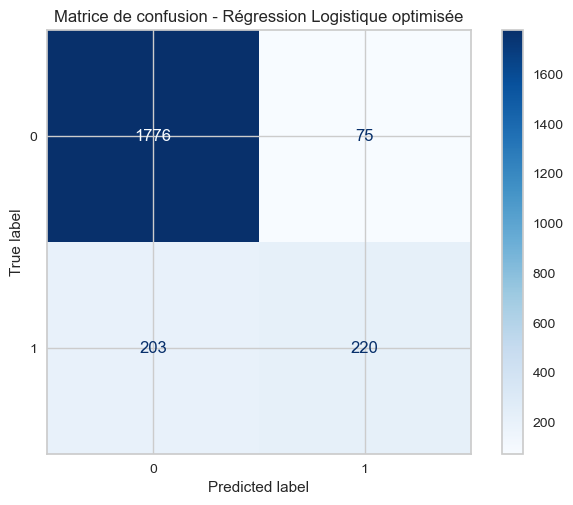

In [157]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Récupération du meilleur modèle entraîné
rl_best_model = rl_grid_search.best_estimator_

# Récupération des classes
class_names = rl_best_model.named_steps['clf'].classes_

# Affichage de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(
    rl_best_model, x_test, y_test,
    display_labels=class_names,
    normalize=None,
    cmap=plt.cm.Blues
)
plt.title("Matrice de confusion - Régression Logistique optimisée")
plt.show()


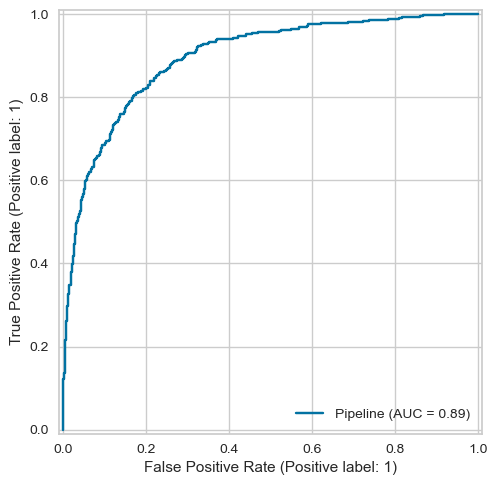

In [158]:
RocCurveDisplay.from_estimator(rl_grid_search.best_estimator_, x_test, y_test)

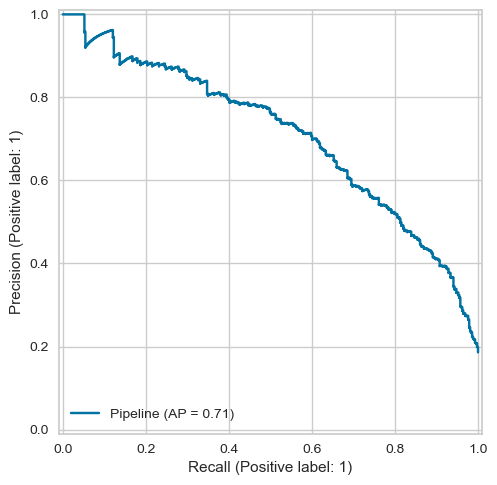

In [159]:
PrecisionRecallDisplay.from_estimator(rl_grid_search.best_estimator_, x_test, y_test);

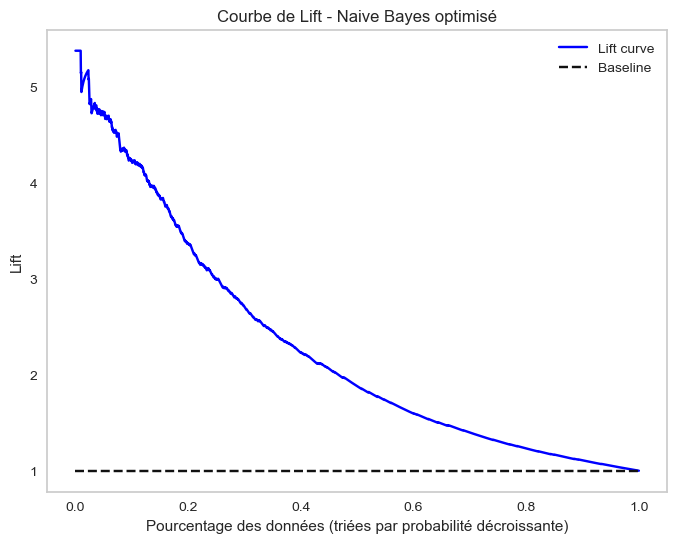

In [160]:
# 1. Prédire les probabilités avec le meilleur modèle
y_pred_proba = rl_grid_search.best_estimator_.predict_proba(x_test)[:, 1]

# 2. Trier les résultats par score décroissant
sorted_indices = np.argsort(y_pred_proba)[::-1]
y_test_sorted = y_test.values[sorted_indices]
y_pred_sorted = y_pred_proba[sorted_indices]

# 3. Calculer le lift
n_samples = len(y_test)
cumulative_y_true = np.cumsum(y_test_sorted)
perc_samples = np.arange(1, n_samples + 1) / n_samples
lift = cumulative_y_true / (perc_samples * cumulative_y_true[-1])

# 4. Tracer la courbe de lift
plt.figure(figsize=(8, 6))
plt.plot(perc_samples, lift, label='Lift curve', color='blue')
plt.plot([0, 1], [1, 1], 'k--', label='Baseline')
plt.xlabel('Pourcentage des données (triées par probabilité décroissante)')
plt.ylabel('Lift')
plt.title('Courbe de Lift - Naive Bayes optimisé')
plt.legend()
plt.grid()
plt.show()

#### Ajustement du seuil

In [140]:


# 1. Séparation en train / validation
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# 2. Utiliser le meilleur modèle RL après GridSearch
rl_best_model = rl_grid_search.best_estimator_

# 3. Prédictions sur le jeu de validation
val_proba = rl_best_model.predict_proba(x_val)[:, 1]

# 4. Liste pour stocker les F1-scores pour différents seuils
f1_scores = []
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    y_pred = (val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

# 5. Seuil qui maximise le F1-score
optimal_f1_threshold = thresholds[np.argmax(f1_scores)]
logger.info(f"Seuil optimal (F1-score, valid set) : {optimal_f1_threshold:.4f}")

# 6. Évaluation finale sur le jeu de test avec ce seuil
test_proba = rl_best_model.predict_proba(x_test)[:, 1]
test_pred_opt_f1 = (test_proba >= optimal_f1_threshold).astype(int)

# 7. Affichage des résultats
logger.info(f"AUC test : {roc_auc_score(y_test, test_proba):.2f}")
logger.info(f"Classification report (seuil optimal sur test) :\n{classification_report(y_test, test_pred_opt_f1)}")


INFO:__main__:Seuil optimal (F1-score, valid set) : 0.3700
INFO:__main__:AUC test : 0.89
INFO:__main__:Classification report (seuil optimal sur test) :
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1851
           1       0.67      0.63      0.65       423

    accuracy                           0.87      2274
   macro avg       0.79      0.78      0.79      2274
weighted avg       0.87      0.87      0.87      2274



In [ ]:
# seuil optimal = 0.37

#### Features importance

  Feature Group  Importance
1       Keyword    0.741762
0          Text    0.660023
2       Has Geo    0.241747


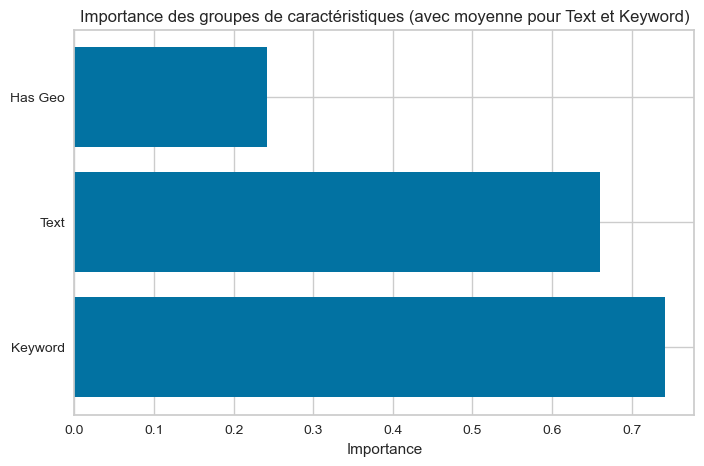

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extraire les coefficients du modèle de régression logistique
coefficients = model.coef_[0]  # Coefficients du modèle binaire

# Nombre de caractéristiques textuelles (par exemple, le nombre de termes dans `text` et `keyword`)
text_feature_names = rl_best_model.named_steps['preprocessor'].transformers_[0][1].named_steps['tfidf'].get_feature_names_out()
num_text_features = len(text_feature_names)

# Coefficients associés aux termes de `text` et `keyword`
coeff_text = coefficients[:num_text_features]
coeff_keyword = coefficients[num_text_features:2*num_text_features]
coeff_has_geo = coefficients[-1]  # Coefficient de `has_geo`

# Calculer l'importance de chaque terme en prenant la valeur absolue du coefficient
importance_text = np.abs(coeff_text)  # Importance des termes dans `text`
importance_keyword = np.abs(coeff_keyword)  # Importance des termes dans `keyword`

# Calculer la moyenne des importances pour `text` et `keyword`
mean_importance_text = np.mean(importance_text)  # Moyenne des importances pour `text`
mean_importance_keyword = np.mean(importance_keyword)  # Moyenne des importances pour `keyword`
importance_geo = np.abs(coeff_has_geo)  # Importance pour `has_geo`

# Créer un DataFrame avec l'importance des groupes de variables
importance_df = pd.DataFrame({
    'Feature Group': ['Text', 'Keyword', 'Has Geo'],
    'Importance': [mean_importance_text, mean_importance_keyword, importance_geo]
})

# Trier par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les résultats
print(importance_df)

# Afficher un graphique
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature Group'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Importance des groupes de caractéristiques (avec moyenne pour Text et Keyword)')
plt.show()



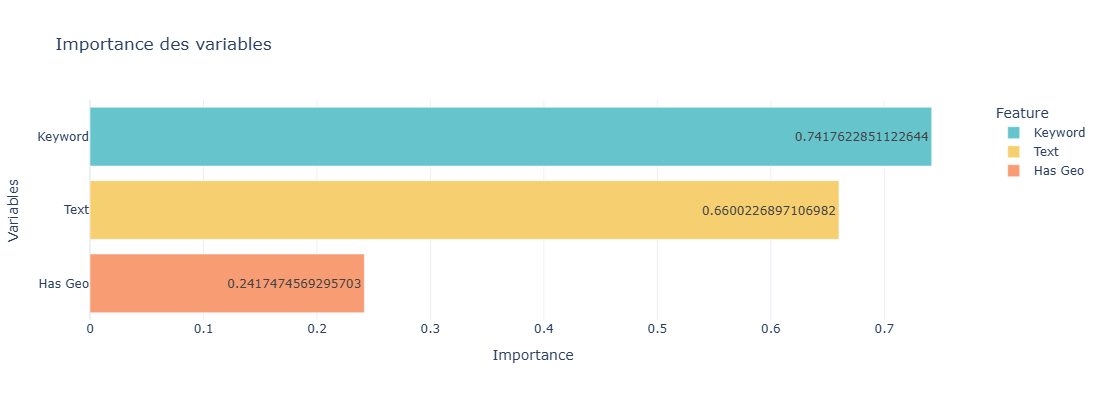

In [198]:
import numpy as np
import pandas as pd
import plotly.express as px

# Extraire les coefficients du modèle de régression logistique
coefficients = model.coef_[0]  # Coefficients du modèle binaire

# Nombre de caractéristiques textuelles (par exemple, le nombre de termes dans `text` et `keyword`)
text_feature_names = rl_best_model.named_steps['preprocessor'].transformers_[0][1].named_steps['tfidf'].get_feature_names_out()
num_text_features = len(text_feature_names)

# Coefficients associés aux termes de `text` et `keyword`
coeff_text = coefficients[:num_text_features]
coeff_keyword = coefficients[num_text_features:2*num_text_features]
coeff_has_geo = coefficients[-1]  # Coefficient de `has_geo`

# Calculer l'importance de chaque terme en prenant la valeur absolue du coefficient
importance_text = np.abs(coeff_text)  # Importance des termes dans `text`
importance_keyword = np.abs(coeff_keyword)  # Importance des termes dans `keyword`

# Calculer la moyenne des importances pour `text` et `keyword`
mean_importance_text = np.mean(importance_text)  # Moyenne des importances pour `text`
mean_importance_keyword = np.mean(importance_keyword)  # Moyenne des importances pour `keyword`
importance_geo = np.abs(coeff_has_geo)  # Importance pour `has_geo`

# Créer un DataFrame avec l'importance des groupes de variables
importance_df = pd.DataFrame({
    'Feature': ['Text', 'Keyword', 'Has Geo'],
    'Importance': [mean_importance_text, mean_importance_keyword, importance_geo]
})

# Trier par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Créer un graphique interactif avec Plotly
fig = px.bar(
    importance_df,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Importance des variables',
    text='Importance',
    color='Feature',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

# Ajuster l'apparence du graphique
fig.update_layout(
    xaxis_title='Importance',
    yaxis_title='Variables',
    template='plotly_white',
    height=400
)

# Ajouter l'option de téléchargement
fig.show()


#### Sauvegarde du model

In [141]:
class RlBestModelOptimized:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict(self, X):
        proba = self.model.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


In [142]:
from pathlib import Path
import dill

# Définir le répertoire et le nom du fichier
MODEL_DIR = r'C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models'
model_path_name = Path(MODEL_DIR, "rl_best_model_optimized.dill")

# Créer l'objet avec le modèle et son seuil
rl_best_model_optimized = RlBestModelOptimized(model=rl_best_model, threshold=optimal_f1_threshold)

# Sauvegarder le modèle et le seuil
logger.info(f"Model path name: {model_path_name}")
with open(model_path_name, "wb") as fp:
    dill.dump(rl_best_model_optimized, fp)

logger.info(f"Model with optimal threshold saved at: {model_path_name}")


INFO:__main__:Model path name: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\rl_best_model_optimized.dill
INFO:__main__:Model with optimal threshold saved at: C:\Users\HP\Desktop\ISEP2\Semestre2\Machine Learning\Projet\Models\rl_best_model_optimized.dill


In [37]:
'''
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Suppose que preprocess_text est déjà défini quelque part

pipeline = Pipeline([
    ("Tout", FunctionTransformer(preprocess_text)),
])

# Exemple
X = pd.Series(["Hello @user 😊! Check this out: https://example.com #NLP #AI 4ao"])
X_transformed = pipeline.fit_transform(X)

print(X_transformed)

'''

['hello ment check url hash hash numberao']
